## Stacking Ensemble Model

**TLDR**: Individually, the models LSTM, SVR, and RNN EPAG have the following performance (MAE / MSE):

- LSTM: 0.399 / 0.379
- SRV: 0.375 / 0.288
- RNN EPAG: 0.485 / 0.480

The naive model, i.e. the simple average across all models per timestep, fails to outperform either of the isolated models.  

Expanding on this, a Random Forest Regressor (with and without BF15_1h_lag0 as exogenous variable) has been trained. The results are as follows (MAE / MSE):

- RFR with BF15_1h_lag0: 0.308 / 0.297
- RFR w/out BF15 variables: 0.309 / 0.304

Additionally, a Linear Regression was performed to compare the RFR output. Although it performs better than the individual models, it fails to outperform the Random Forest Classifier:

- Linear Regression with BF15_1h_lag0: 0.329 / 0.278

In [1]:
import pandas as pd
import numpy as np

from models.utility import load_input, scale_with_minmax, get_dates_from_config, handle_outliers, inverse_transform_minmax, split_dataframe
from models.deeplearner import DeepLearner

from solutil import evaluations as ev
from solutil import feature_selection as fs

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid

### Data Import

In [2]:
# CSV Import YPred
df_lstm = pd.read_csv('experiments/stacking_data/ypred_lstm.csv', index_col=0)
df_svr = pd.read_csv('experiments/stacking_data/ypred_svr.csv', index_col=0)
df_bm = pd.read_csv('experiments/stacking_data/ypred_benchmark_4h.csv', index_col=0)

In [3]:
# CSV Import Features
df_features = pd.read_csv('experiments/stacking_data/features_lstm.csv', index_col=0)
df_solofeat = df_features.copy().drop(columns=['temp_1h_lag1', 'glob_1h_lag2', 'glob_1h_lag3',
                                               'rain_1h_lag1', 'schmelz_1h_lag1'])

In [4]:
df_features

,base_lag0,base_1d_lag0,temp_1h_lag0,temp_1h_lag1,glob_1h_lag1,glob_1h_lag2,glob_1h_lag3,rain_1h_lag0,rain_1h_lag1,bf15_1h_lag0,schmelz_1h_lag0,schmelz_1h_lag1,rain_1h_prog_lag-6,glob_1h_prog_lag-6,temp_1h_prog_lag-6,yearday_sin,yearday_cos
2021-03-02 00:00:00+01:00,1.575118,1.616138,3.485418,3.056250,0.000000,67.564583,471.766667,0.000000,0.000000,1.126800,0.056250,0.054175,0.0,0.00000,11.4300,0.867456,0.497513
2021-03-02 04:00:00+01:00,1.425177,1.616138,3.687498,3.485418,0.000000,0.000000,67.564583,0.000000,0.000000,1.123125,0.068350,0.056250,0.0,0.00000,11.4300,0.868880,0.495022
2021-03-02 08:00:00+01:00,1.275315,1.616138,6.229167,3.687498,7.622917,0.000000,0.000000,0.000000,0.000000,1.124425,0.086225,0.068350,0.0,0.00000,11.4300,0.870297,0.492528
2021-03-02 12:00:00+01:00,1.767134,1.616138,10.293767,6.229167,372.379167,7.622917,0.000000,0.000000,0.000000,1.112425,0.097900,0.086225,0.0,0.00000,11.4300,0.871706,0.490029
2021-03-02 16:00:00+01:00,1.832819,1.616138,7.958333,10.293767,492.562500,372.379167,7.622917,0.000000,0.000000,1.103950,0.080825,0.097900,0.0,0.00000,11.4300,0.873109,0.487526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-04 08:00:00+01:00,4.200000,4.200000,14.372917,9.983333,145.123958,0.804167,0.261458,0.000000,0.010833,1.073854,0.000000,0.000000,0.0,632.46875,17.8125,-0.057193,-0.998363
2024-07-04 12:00:00+01:00,4.200000,4.200000,16.922917,14.372917,606.752083,145.123958,0.804167,0.000000,0.000000,1.055875,0.000000,0.000000,0.0,648.38750,20.1250,-0.060049,-0.998195
2024-07-04 16:00:00+01:00,4.200000,4.200000,15.914583,16.922917,436.929167,606.752083,145.123958,0.000000,0.000000,1.053896,0.000000,0.000000,0.0,181.88125,19.0925,-0.062905,-0.998020
2024-07-04 20:00:00+01:00,4.200000,4.200000,14.068750,15.914583,113.851042,436.929167,606.752083,0.007083,0.000000,1.057937,0.000000,0.000000,0.0,0.61875,16.7700,-0.065760,-0.997835


In [5]:
# Dataframe Stacking & Handling
df_step1 = df_lstm.merge(right=df_svr, how='outer', left_index=True, right_index=True)
df_inlet1 = df_step1.merge(right=df_bm, how='inner', left_index=True, right_index=True)
df_inlet1.drop(columns=['ytest_svr', 'act_inlet1', 'act_inlet2', 'pred_inlet2'], inplace=True)
df_inlet1.dropna(inplace=True)
df_inlet1.rename(columns={'pred_inlet1':'ypred_rnn_inl1'}, inplace=True)

In [6]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1
2023-07-12 08:00:00+01:00,2.226492,1.141217,1.783905,1.370952
2023-07-12 12:00:00+01:00,2.437171,1.567794,1.688257,2.019556
2023-07-12 16:00:00+01:00,2.570486,1.387117,1.856551,2.787662
2023-07-12 20:00:00+01:00,2.927256,4.027856,2.517361,3.587425
2023-07-13 00:00:00+01:00,2.784724,4.200000,3.504087,1.219145
...,...,...,...,...
2024-06-30 20:00:00+01:00,4.160791,4.200000,3.840700,3.754528
2024-07-01 00:00:00+01:00,4.114718,4.200000,3.875438,3.795551
2024-07-01 04:00:00+01:00,4.076244,4.200000,4.086108,3.778045
2024-07-01 08:00:00+01:00,4.157660,4.200000,4.265880,3.755074


### Feature Analysis

C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascience\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Program Files\Python\venv311_datascie

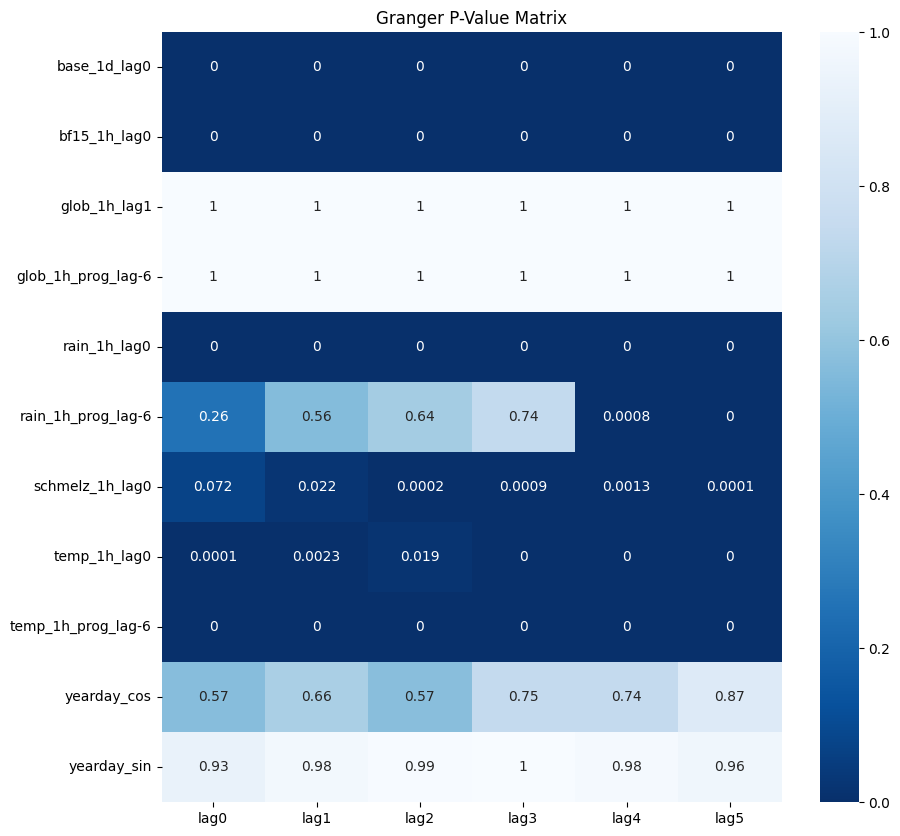

In [7]:
# Calculate Granger Causality Tests
granger = fs.granger_causality_test(df=df_solofeat, target_var='base_lag0', annot=True)

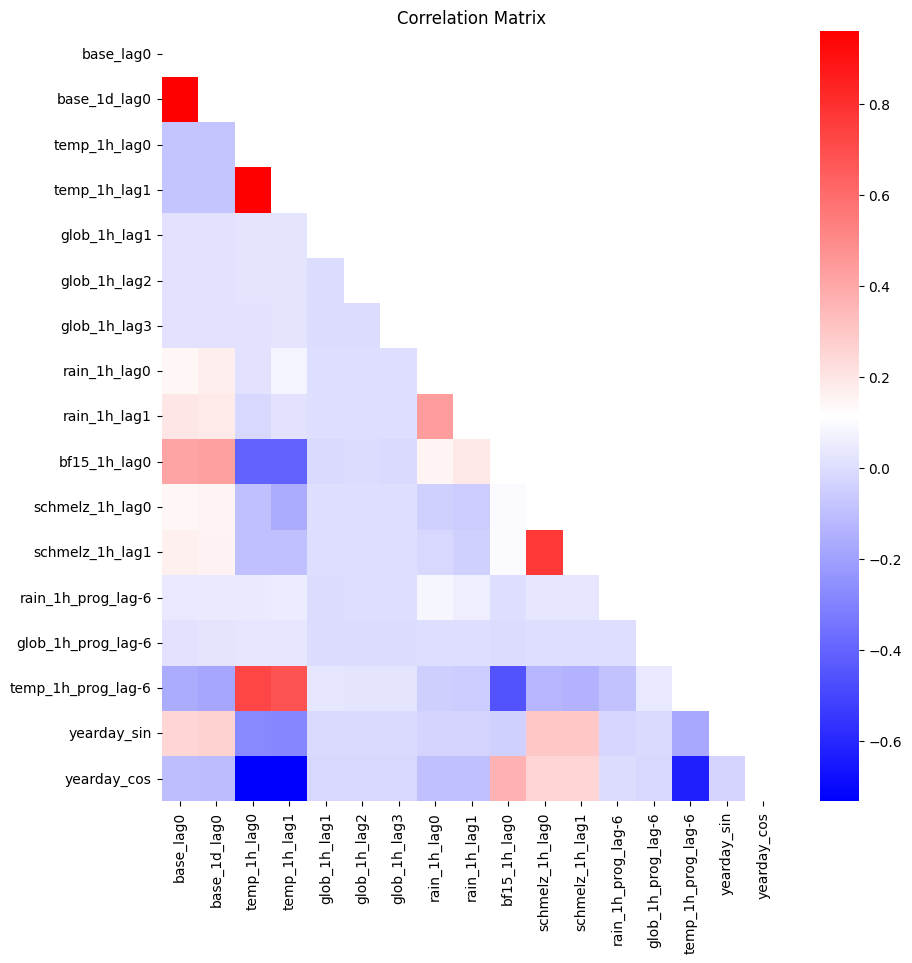

In [8]:
# Calculate Correlogram
corr_matrix = fs.correlation_matrix(df_features, method='pearson')

### Sample Preparation for ML Models

In [9]:
# Add most relevant feature
df_inlet1['bf15_1h_lag0'] = df_features['bf15_1h_lag0']

In [10]:
df_inlet1

,ypred_lstm,ytest,ypred_svr,ypred_rnn_inl1,bf15_1h_lag0
2023-07-12 08:00:00+01:00,2.226492,1.141217,1.783905,1.370952,0.715188
2023-07-12 12:00:00+01:00,2.437171,1.567794,1.688257,2.019556,0.734208
2023-07-12 16:00:00+01:00,2.570486,1.387117,1.856551,2.787662,0.879000
2023-07-12 20:00:00+01:00,2.927256,4.027856,2.517361,3.587425,1.016792
2023-07-13 00:00:00+01:00,2.784724,4.200000,3.504087,1.219145,0.975896
...,...,...,...,...,...
2024-06-30 20:00:00+01:00,4.160791,4.200000,3.840700,3.754528,1.031563
2024-07-01 00:00:00+01:00,4.114718,4.200000,3.875438,3.795551,1.035562
2024-07-01 04:00:00+01:00,4.076244,4.200000,4.086108,3.778045,1.078021
2024-07-01 08:00:00+01:00,4.157660,4.200000,4.265880,3.755074,1.115583


In [11]:
# Min Max Scaling
df_inlet1_scaled = scale_with_minmax(df_features=df_inlet1, str_model='inlet1_ens')

In [12]:
# Split dataframe
x_train, x_test, y_train, y_test = split_dataframe(df_features=df_inlet1_scaled, target_var='ytest')

### Ensemble Model Construction

#### Isolated Predictions

In [13]:
# Get Date Limits for Test Set 
start_date = y_test.index[0]
end_date = y_test.index[-1]

In [14]:
df_inlet_short = df_inlet1.loc[(df_inlet1.index >= start_date) & (df_inlet1.index <= end_date)]

**LSTM**

In [15]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_lstm'])

{'mae': 0.3716437759156527,
 'mse': 0.38798892987228173,
 'rmse': 0.6228875740230188,
 'mape': 37148719841280.23,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

**SVR**

In [16]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_svr'])

{'mae': 0.38244001104897596,
 'mse': 0.2790600802940647,
 'rmse': 0.5282613749783952,
 'mape': 26302958052696.62,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

**RNN EPAG**

In [17]:
ev.get_eval_metrics(df_inlet_short['ytest'], df_inlet_short['ypred_rnn_inl1'])

{'mae': 0.49408151654931454,
 'mse': 0.48884886958792634,
 'rmse': 0.6991772805146963,
 'mape': 47416127087047.52,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

#### Naive Model

In [18]:
x_test_naive = x_test.drop(columns=['bf15_1h_lag0'])

In [19]:
ypred_naive = x_test_naive.mean(axis=1)

In [20]:
# Rescale predictions
y_pred_naive_rescaled = inverse_transform_minmax(df_scaled=ypred_naive, str_model='inlet1_ens', attributes='ytest')
y_test_rescaled = inverse_transform_minmax(df_scaled=y_test, str_model='inlet1_ens', attributes='ytest')

In [21]:
ev.get_eval_metrics(y_test_rescaled, y_pred_naive_rescaled)

{'mae': 0.5117537299771027,
 'mse': 0.39515993069758415,
 'rmse': 0.6286174756539816,
 'mape': 34197230686182.438,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

#### Random Forest Regressor with BF15_1h_lag0

**Grid Search**

In [22]:
# Instantiate RFR
grid_forest = RandomForestRegressor(n_jobs=-1)

In [23]:
# Define Parameter Grid
hyperparams = {
   'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 8, 16, 32, 64],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 4, 8, 16]
}

param_grid = ParameterGrid(hyperparams)

In [24]:
# Instantiate Grid Search Object
rfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [25]:
rfr_gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [26]:
# Output Results
print(f"Best Parameters: {rfr_gridsearch.best_params_}")
print(f"Best Score: {rfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Best Score: -0.010780566964556206


- Best Parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
- Best Score: -0.012115434320588073

**Random Forest Model**

In [27]:
# Define hyperparameters
best_params = {'max_depth': 32, 
               'min_samples_leaf': 8, 
               'min_samples_split': 8, 
               'n_estimators': 100}

In [28]:
# Parameterize model
forest = RandomForestRegressor(**rfr_gridsearch.best_params_)

In [29]:
# Train model
trained_forest = forest.fit(x_train, y_train)

In [30]:
# Predict inlet1
ypred_rfr = trained_forest.predict(x_test)

In [31]:
# Rescale predictions
y_pred_rfr_rescaled = inverse_transform_minmax(df_scaled=ypred_rfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

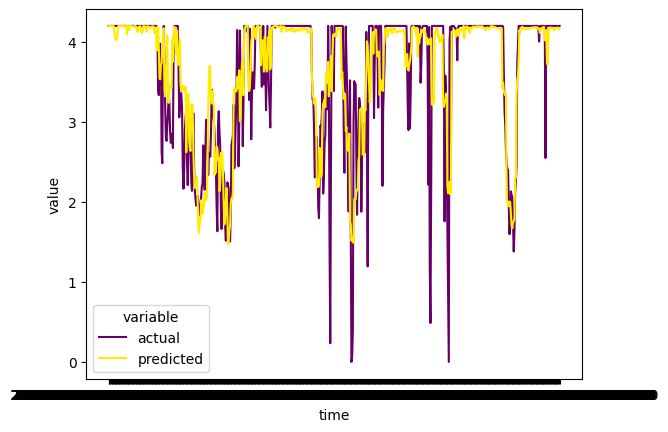

In [32]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_rfr_rescaled)

In [33]:
ev.get_eval_metrics(y_test_rescaled, y_pred_rfr_rescaled)

{'mae': 0.299129540145768,
 'mse': 0.29099291142889566,
 'rmse': 0.5394375880756694,
 'mape': 26042322684278.508,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

#### Endogenous Random Forest Regressor

In [34]:
# Drop exogenous variables
x_train_pure = x_train.drop(columns=['bf15_1h_lag0'])
x_test_pure = x_test.drop(columns=['bf15_1h_lag0'])

**Grid Search**

In [35]:
# Instantiate Grid Search Object
purerfr_gridsearch = GridSearchCV(estimator=grid_forest, param_grid=hyperparams, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3)

In [36]:
purerfr_gridsearch.fit(x_train_pure, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [37]:
# Output Results
print(f"Best Parameters: {purerfr_gridsearch.best_params_}")
print(f"Best Score: {purerfr_gridsearch.best_score_}")

Best Parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Best Score: -0.010466268712433545


**RFR Model**

In [38]:
# Define hyperparameters
pure_params = {'max_depth': 64, 
               'min_samples_leaf': 8, 
               'min_samples_split': 4, 
               'n_estimators': 200}

In [39]:
# Parameterize model
pure_forest = RandomForestRegressor(**purerfr_gridsearch.best_params_)

In [40]:
# Train model
trained_pureforest = pure_forest.fit(x_train_pure, y_train)

In [41]:
# Predict inlet1
ypred_purerfr = trained_pureforest.predict(x_test_pure)

In [42]:
# Rescale predictions
y_pred_purerfr_rescaled = inverse_transform_minmax(df_scaled=ypred_purerfr, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

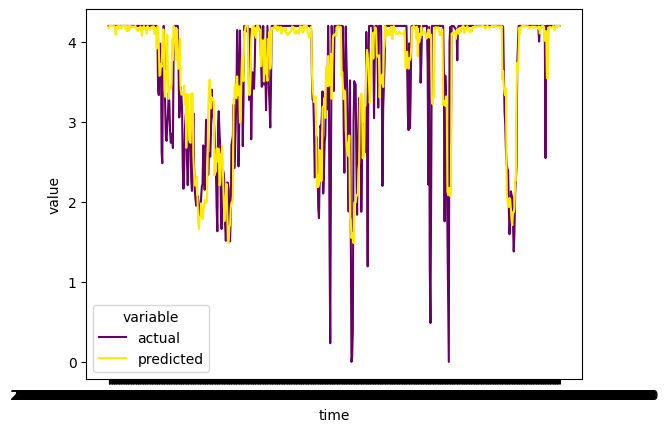

In [43]:
ev.get_act_vs_pred_plot(y_test_rescaled, y_pred_purerfr_rescaled)

In [44]:
ev.get_eval_metrics(y_test_rescaled, y_pred_purerfr_rescaled)

{'mae': 0.3001056105921243,
 'mse': 0.2959194245425066,
 'rmse': 0.5439847649911774,
 'mape': 26228078782689.17,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}

#### Linear Regression

In [45]:
linreg = LinearRegression()

In [46]:
trained_reg = linreg.fit(x_train, y_train)

In [47]:
ypred_linreg = trained_reg.predict(x_test)

In [48]:
ypred_linreg_rescaled = inverse_transform_minmax(df_scaled=ypred_linreg, str_model='inlet1_ens', attributes='ytest')

<Axes: xlabel='time', ylabel='value'>

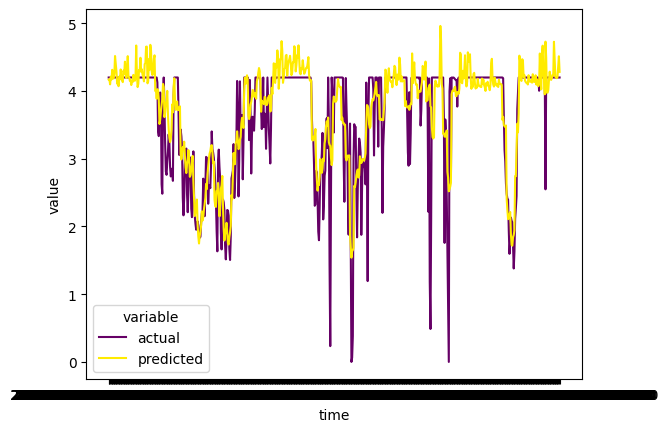

In [49]:
ev.get_act_vs_pred_plot(y_test_rescaled, ypred_linreg_rescaled)

In [50]:
ev.get_eval_metrics(y_test_rescaled, ypred_linreg_rescaled)

{'mae': 0.3206246399728152,
 'mse': 0.2615658474840902,
 'rmse': 0.5114350862857281,
 'mape': 28556720526937.98,
 'non-na%': 1.0,
 'n_actual_obs': 640,
 'n_pred_nas': 0}